# Think Bayes - Chapter 6

Following A. B. Downey's book *Think Bayes*, but using Julia as opposed to Python

In [1]:
using Statistics, Distributions, Plots, Printf

## Gluten sensitivity problem

$N$ people are asked to pick the bread containing gluten. There are three possoble outcomes:
* Person identifies gluten, i.e. picks the right bread
* Person picks the wrong bread
* Fails to distinguish

Imagine gluten-sensitive person has $0.9$ chance of identifying gluten, whilst gluten-insensitive person has $0.33\dots$ chance of identifying the correct bread. Given $N$ trials with $m$ correct identifications how likely is a certain ratio of gluten-sensitive people amongst the cohort?

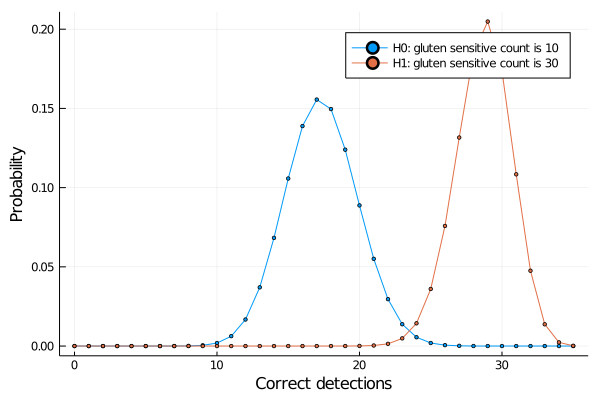

In [70]:
function single_pick_prob(;
    pick_correct_count::Int64,
    pick_wrong_count::Int64,
    gluten_sensitive_count::Int64,
    gluten_sensitive_pick_prob::Float64=0.90,
    gluten_insens_pick_prob::Float64=1/3
)
    """
    Compute the probability of N=pick_correct_count+pick_wrong_count
    people picking pick_correct_count gluten-containing products assuming
    that gluten-sensitive people have gluten_sensitive_pick_prob probability
    of picking correctly whilst gluten-insensitive have gluten_insens_pick_prob
    probability
    """
    
    # total number of experiments conducted
    pick_count = pick_correct_count + pick_wrong_count
    
    # sanity check
    if gluten_sensitive_count > pick_count
        throw(ArgumentError("Need gluten_sensitive_count <= pick_correct_count + pick_wrong_count)"))
    end
    
    # sanity check
    if gluten_sensitive_count < 0
        throw(ArgumentError("Need gluten_sensitive_count > 0"))
    end
    
    # go through all possible combinations
    # people. automatically other breads were correctly detected 
    # by gluten insensitive people 
    picked_corr_by_gluten_sensitive_arr = Array(
        0:minimum([pick_correct_count, gluten_sensitive_count])
    )
    #
    picked_corr_by_gluten_insens_arr = pick_correct_count .- picked_corr_by_gluten_sensitive_arr

    # compute probabilities of combinations
    prob_gsens_arr = pdf.(
        Binomial(gluten_sensitive_count, gluten_sensitive_pick_prob),
        picked_corr_by_gluten_sensitive_arr
    )
    #
    prob_gins_arr = pdf.(
        Binomial(pick_count-gluten_sensitive_count, gluten_insens_pick_prob),
        picked_corr_by_gluten_insens_arr
    )
        
    # collapse to compute pick probability
    pick_prob = sum(prob_gsens_arr .* prob_gins_arr)
    
    return pick_prob
end
    
#### 
    
function pick_prob(;
    pick_count::Int64,
    pick_correct_count_arr::Array{Int64},
    gluten_sensitive_count::Int64,
    gluten_sensitive_pick_prob::Float64=0.90,
    gluten_insens_pick_prob::Float64=1/3
)::Array{Float64}
    """
    Vectorize single_pick_prob. For pick_count picks of bread and 
    every number of correct picks from pick_correct_count_arr
    given the number of gluten_sensitive_count gluten senstive 
    people in the cohort, compute the probability of the correct picks
    being made and return as an array.
        
    Simply loop through every pick_correct_count_arr and apply single_pick_prob
    """

    pick_prob_arr = zeros(length(pick_correct_count_arr))

    for (i_prob, pick_corr) in enumerate(pick_correct_count_arr)
        pick_prob_arr[i_prob] = single_pick_prob(;
            pick_correct_count=pick_corr,
            pick_wrong_count=pick_count-pick_corr,
            gluten_sensitive_count=gluten_sensitive_count,
            gluten_sensitive_pick_prob=gluten_sensitive_pick_prob,
            gluten_insens_pick_prob=gluten_insens_pick_prob
        )
    end
        
    return pick_prob_arr
end

####

# Try out two hypothesis

pick_count = 35
pick_correct_arr = Array(0:pick_count)
gluten_sensitive_count_h0 = 10
gluten_sensitive_count_h1 = 30

pick_prob_h0_arr = pick_prob(
    pick_count=pick_count,
    pick_correct_count_arr=pick_correct_arr,
    gluten_sensitive_count=gluten_sensitive_count_h0
)

pick_prob_h1_arr = pick_prob(
    pick_count=pick_count,
    pick_correct_count_arr=pick_correct_arr,
    gluten_sensitive_count=gluten_sensitive_count_h1
)
    
####
    
plot(
    pick_correct_arr,
    pick_prob_h0_arr,
    label=@sprintf("H0: gluten sensitive count is %d", gluten_sensitive_count_h0),
    marker=2,
    xlabel="Correct detections",
    ylabel="Probability"
)
#
plot!(
    pick_correct_arr,
    pick_prob_h1_arr,
    label=@sprintf("H1: gluten sensitive count is %d", gluten_sensitive_count_h1),
    marker=2
)
#


In [73]:
sum(pick_prob_h1_arr)

0.9999999999999999